<a href="https://colab.research.google.com/github/badlogic/genai-workshop/blob/main/03_unsupervised_learning_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Embeddings
Embedding models are a type of unsupervised machine learning model. They learn how to take text, images, or audio and transform it into a vector in what's called a **latent (vector) space**. This process is commonly referred to as embedding.

This process is different than just taking measurements like a car's number of cylinders, top speed, or tank capacity, and giving each of those features its own dimension in a vector.

Instead, embedding models take such "plain" feature vectors as input and find what's called **latent variables** in them. These may or may not have a correlate in the real world. E.g. when embedding images of faces, one such latent variable could be the orientation of the face, e.g. left or right, or the skin tone, or whether the eyes are open or closed. Some latent variables may also have no real-world correlate, but still encode something semantically meaningful. A single dimension in the resulting vector space (or element in a resulting embedding vector) therefore usually doesn't correlate with a single real-world property, like a face's direction. Instead, a latent variable may make up an area within that high-dimensional space.

Ultimately, what meaning the individual dimensions in a latent space have, is often not explainable.

The benefit of embedding data into a latent space is that we can then use simple mathematical tools to compare the (semantic) similarity between two data, e.g. two sentences, or two images. It also serves as a form of automatic feature engineering, where the embedding model figures out discriminating properties in the data, by which dissimilar items can be discerned.

This has an enormous amount of applications, both directly, and indirectly as part of bigger systems (including large language models!).

> **Note:** while we are discussing embeddings for full texts, there are also [word embeddings](https://en.wikipedia.org/wiki/Word_embedding), which play an important role in large language models.


# Playing with embeddings
To illustrate the power of embeddings, we are going to use a pre-trained text embedding model called `jina-embeddings-v2-base-de` from Hugging Face. The specific model can handle both English and German language texts. In fact, multi-linguality is a property of many popular text embedding models.

We will embed textual information about movies (title and description) and implement two popular "downstream" tasks for embeddings:

1. Finding similar movies (recommender)
2. Finding movies that are match a user query (retrieval)

## Setup and Hugging Face login
To use the jina model, you have to:
1. Create a [Hugging Face account](https://huggingface.co/join)
2. Create an [access token](https://huggingface.co/settings/tokens)
3. Visit the [model page](https://huggingface.co/jinaai/jina-embeddings-v2-base-de) and request access.

If you run the code on your own machine, set the `HF_TOKEN` environment variable to your access token.

If you run the code here on collab, you will be prompted for your token each time you run this cell.

In [1]:
!pip install umap-learn
import numpy as np
from numpy.linalg import norm
from transformers import AutoModel
import umap
import matplotlib.pyplot as plt
import os

# Check if HF_TOKEN exists in the environment, otherwise fetch it from the colab
# secrets
if 'HF_TOKEN' in os.environ:
  print("Using 🤗 access token from HF_TOKEN environment variable")
else:
  from huggingface_hub import notebook_login
  notebook_login()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 6.2 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=2e9ca92da2128eade449f2ecc53152ff455eb7c966bd224b41516d7db3356cd5
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


## Loading the embedding model

Now that we are logged in, we can use the Hugging Face `AutoModel` class download and load the model. We refer to the model via its id, which is composed of the author name and model name, e.g. `jinaai/jina-embeddings-v2-base-de`.

Alternatively, we can also point the `AutoModel` class to a local directory that contains an already downloaded model.

In [3]:
model = AutoModel.from_pretrained('jinaai/jina-embeddings-v2-base-de', trust_remote_code=True)

config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

configuration_bert.py:   0%|          | 0.00/8.24k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/jina-bert-implementation:
- configuration_bert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_bert.py:   0%|          | 0.00/97.7k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/jina-bert-implementation:
- modeling_bert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/322M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.01M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/589k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.63M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

We can generate an embedding vector for a text like this:

In [4]:
import pandas as pd
embedding_vector = model.encode("Peach is in another castle")
pd.DataFrame(embedding_vector, columns=["Value for dimension"])

,Value for dimension
0,0.180843
1,0.151644
2,0.013982
3,0.006152
4,-0.416204
...,...
763,0.092240
764,-0.013817
765,0.085648
766,-0.073061


The vector has 768 dimensions.

## Similarity and distance functions
As described above, we can use standard distance metrics and similarity measures. Two popular ones are [euclidian distance (also known as L2-Norm)](https://en.wikipedia.org/wiki/Euclidean_distance) and [cosine similiarity](https://en.wikipedia.org/wiki/Cosine_similarity).

Euclidian distance measures the distance between two points as if we'd walk from one point to the other in a straight line.

With cosine similarity, we measure the angle between two points, with -1 being the most disimilar and 1 being the most similar.

Let's define two functions, that given two input vectors, calculate the euclidian distance and cosine similarity respectively.

In [5]:
cosine_similarity = lambda a,b: (a @ b.T) / (norm(a)*norm(b))
l2_norm = lambda a,b: np.linalg.norm(a-b)

We'll evaluate which of these two functions gives better results for the tasks we implement below.

## Movie dataset

We define a simple dataset inline. It consists of a handful of movies, each consisting of a title and plot. These have been manually fetched from IMDB. We could of course also load such a dataset from a file or via an API. We keep things simple here.

In [6]:
raw_movies = [
  ("Star Trek: Generations", "With the help of long presumed dead Captain Kirk, Captain Picard must stop a deranged scientist willing to murder on a planetary scale in order to enter a space matrix."),
  ("Star Wars: Episode V - The Empire Strikes Back", "After the Rebels are overpowered by the Empire, Luke Skywalker begins his Jedi training with Yoda, while his friends are pursued across the galaxy by Darth Vader and bounty hunter Boba Fett."),
  ("Pulp Fiction", "The lives of two mob hitmen, a boxer, a gangster and his wife, and a pair of diner bandits intertwine in four tales of violence and redemption."),
  ("Fight Club", "An insomniac office worker and a devil-may-care soap maker form an underground fight club that evolves into much more."),
  ("Ghostbusters", "Three parapsychologists forced out of their university funding set up shop as a unique ghost removal service in New York City, attracting frightened yet skeptical customers."),
  ("Ghostbusters II", "The discovery of a massive river of ectoplasm and a resurgence of spectral activity allows the staff of Ghostbusters to revive the business."),
  ("The Silence of the Lambs", "In this thriller, a young F.B.I. cadet must receive the help of an incarcerated and manipulative cannibal killer to help catch another serial killer, a madman who skins his victims."),
  ("Seven", "Two detectives, a rookie and a veteran, hunt a serial killer who uses the seven deadly sins as his motives."),
  ("The Lord of the Rings", "A meek Hobbit from the Shire and eight companions set out on a journey to destroy the powerful One Ring and save Middle-earth from the Dark Lord Sauron."),
  ("The Hobbit", "A reluctant Hobbit, Bilbo Baggins, sets out to the Lonely Mountain with a spirited group of dwarves to reclaim their mountain home, and the gold within it from the dragon Smaug."),
  ("The Jungle Book", "In this classic Disney movie, Bagheera the Panther and Baloo the Bear have a difficult time trying to convince a boy to leave the jungle for human civilization."),
  ("Peter Pan", "In this beautifully drawn animation film, Wendy and her brothers are whisked away to the magical world of Neverland with the hero of their stories, Peter Pan.")
]

## Creating embedding vectors for each movie
We embed both the title and plot as a single string for each movie, then create a Pandas `DataFrame` of movies, where each movie tuple consists of the emebdding vector, the title, and the plot of the movie.

In [7]:
embeddings = model.encode([raw_movie[0] + " " + raw_movie[1] for raw_movie in raw_movies])
movies = pd.DataFrame([(embedding, movie[0], movie[1]) for embedding, movie in zip(embeddings, raw_movies)], columns=["vector", "title", "plot"])
movies


,vector,title,plot
0,"[-0.15949629, -0.26931834, 0.12828855, 0.03978...",Star Trek: Generations,With the help of long presumed dead Captain Ki...
1,"[-0.18870552, 0.13675152, -0.12258701, 0.03999...",Star Wars: Episode V - The Empire Strikes Back,After the Rebels are overpowered by the Empire...
2,"[-0.09221994, 0.021838395, -0.09498616, -0.111...",Pulp Fiction,"The lives of two mob hitmen, a boxer, a gangst..."
3,"[0.14404602, 0.27673542, -0.39927807, -0.20871...",Fight Club,An insomniac office worker and a devil-may-car...
4,"[-0.0838464, -0.3563486, 0.15748197, 0.0007547...",Ghostbusters,Three parapsychologists forced out of their un...
5,"[-0.045377046, -0.05466573, 0.21167399, 0.0401...",Ghostbusters II,The discovery of a massive river of ectoplasm ...
6,"[0.105173394, -0.030302089, -0.20176488, 0.242...",The Silence of the Lambs,"In this thriller, a young F.B.I. cadet must re..."
7,"[0.08146318, -0.17932993, -0.08796415, 0.12017...",Seven,"Two detectives, a rookie and a veteran, hunt a..."
8,"[-0.28501946, 0.07704591, 0.014699279, 0.01563...",The Lord of the Rings,A meek Hobbit from the Shire and eight compani...
9,"[-0.1872434, 0.1322996, -0.056449857, 0.066059...",The Hobbit,"A reluctant Hobbit, Bilbo Baggins, sets out to..."


## Visualizing the embeddings with UMAP
As we've seen, the jina model generates vectors with 768 dimensions. It is hard to visualize such high dimensional vector spaces in our heads.

To get a better feeling for how these vectors relate to each other, we can use another embedding model, that will reduce the dimensionality down to 2 or 3 dimensions, while trying to retain the distances between the vectors as best as possible.

One popular such model is [UMAP](https://pair-code.github.io/understanding-umap/).

Let's visualize our embedded movies in 2D and see if we can identify clusters. The `visualize_embeddings` function takes as input the embedding vectors and their labels, and optionally a metric, either "cosine" or "l2". It will embed these vectors in 2D via UMAP and plot them.

Let's plot the embedding using UMAP, using both the cosine and the L2 norm.

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


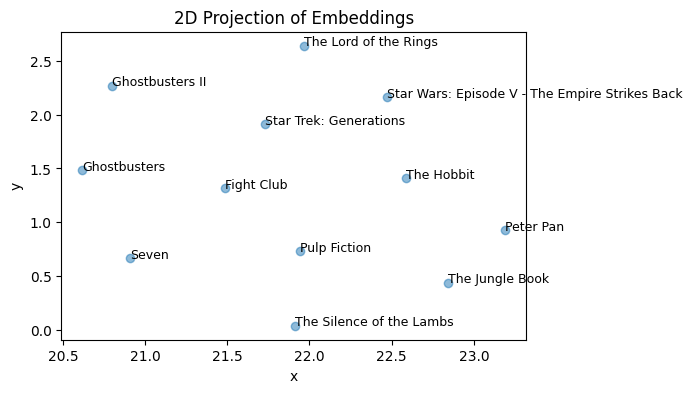

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


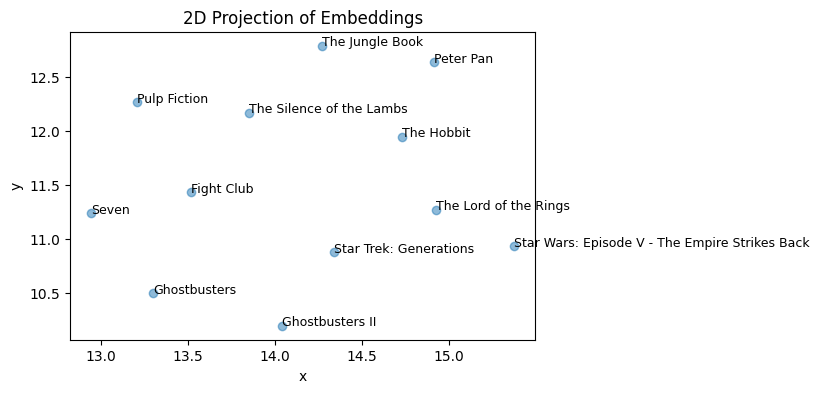

In [8]:
def visualize_embeddings(embeddings, labels, dist_func="cosine"):
  reducer = umap.UMAP(n_neighbors=min(15, len(embeddings)), n_components=2, metric=dist_func)
  embeddings_2d = np.array(reducer.fit_transform(embeddings))

  plt.figure(figsize=(6, 4))
  plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5)

  for i, label in enumerate(labels):
      plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], label, fontsize=9)

  plt.title('2D Projection of Embeddings')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.show()

visualize_embeddings(movies.vector.to_list(), movies.title, "cosine")
visualize_embeddings(movies.vector.to_list(), movies.title, "l2")

It doesn't seem to make a big difference what distance or similarity measure we use. We'll go with cosine similarity by default, as that's usually the default pick in other systems.

## Similarity search
We can now use those embeddings to find movies that are similar to a query. The query could be anything, like a user query, or the title and plot of another movie.

We can wrap this idea up in a function called `similarity_search`. Its parameters are as follows:

* **`query`**: a string or vector to find similar movies for
* **`embeddings`**: the list of vectors for each movie
* **`labels`**: the list of labels for each vector, e.g. the movie titles

The function first embeds the query text, if it isn't already an vector. It then calculates the cosine similarity between the query text vector and the movie vectors and stores the resulting similarity and corresponding movie in a list. Finally, the similarity list is sorted in descending order by similarity, and returned to the caller.

In [9]:
def similarity_search(query, embeddings, labels, dist_func=cosine_similarity):
  query_embedding = embed(query) if isinstance(query, str) else query
  similarities = []
  for i in range(len(movies)):
    similarity = dist_func(query_embedding, embeddings[i])
    similarities.append((movies[i], similarity))

  similarities.sort(key=lambda x: x[1], reverse=True)
  return similarities

# Naive movie recommender
Let's implement a movie recommender function. It takes as input:

* `movie`: the movie for which we want to get recommendations
* `movies`: the full list of movies (including the `movie`)
* `embeddings`: the embeddings of each movie

The function returns a list of tuples, each consisting of a movie and its similarity with the input `movie`. The list is sorted by similarity in descending order.



In [10]:
def recommend_movies(selected_movie, movies_df, dist_func=cosine_similarity):
    embedding = np.array(selected_movie['vector'])

    def calculate_distances(row):
        other_embedding = np.array(row['vector'])
        return cosine_similarity(embedding, other_embedding)

    movies_df['distance'] = movies_df.apply(calculate_distances, axis=1)
    movies_to_recommend = movies_df[movies_df['title'] != selected_movie['title']]
    recommended_movies = movies_to_recommend.sort_values(by='distance', ascending=False)
    return recommended_movies[['title', 'plot', 'distance']]

We can now output the list of most similar movies, for each movie:

In [11]:
for index, selected_movie in movies.iterrows():
    print(f"Recommended movies for {selected_movie['title']}:")
    recommendations = recommend_movies(selected_movie, movies)
    for _, row in recommendations.iterrows():
        print(f"\t{row['title']}: {row['distance']:.2f}")
    print()

Recommended movies for Star Trek: Generations:
	Star Wars: Episode V - The Empire Strikes Back: 0.25
	Seven: 0.24
	The Lord of the Rings: 0.19
	The Hobbit: 0.15
	Pulp Fiction: 0.15
	The Silence of the Lambs: 0.13
	Fight Club: 0.11
	Ghostbusters II: 0.10
	Peter Pan: 0.09
	Ghostbusters: 0.05
	The Jungle Book: 0.03

Recommended movies for Star Wars: Episode V - The Empire Strikes Back:
	Star Trek: Generations: 0.25
	The Lord of the Rings: 0.21
	The Jungle Book: 0.13
	Fight Club: 0.12
	Peter Pan: 0.11
	Ghostbusters II: 0.05
	Pulp Fiction: 0.04
	The Hobbit: 0.04
	Seven: 0.02
	The Silence of the Lambs: 0.02
	Ghostbusters: -0.02

Recommended movies for Pulp Fiction:
	Fight Club: 0.38
	The Silence of the Lambs: 0.35
	Seven: 0.33
	Peter Pan: 0.30
	The Jungle Book: 0.28
	The Hobbit: 0.19
	Ghostbusters II: 0.17
	Ghostbusters: 0.16
	Star Trek: Generations: 0.15
	The Lord of the Rings: 0.13
	Star Wars: Episode V - The Empire Strikes Back: 0.04

Recommended movies for Fight Club:
	Pulp Fiction: 0.38

This matches expectation for the most part! In a less naive recommender system, we'd use more intricate signals in addition to semantic similarity of two movies' titles and plots, such as taking into account what other people have watched. See [Collaborative Filtering](https://en.wikipedia.org/wiki/Collaborative_filtering).

# Naive dense retrieval
Retrieval is generally defined as finding relevant information, like text, image, or audio documents, for a given query. There are multiple ways to implement such retrieval systems, which are also known as "search engines". Here we'll focus on text retrieval.

Up until recently, most search engines used "sparse" retrieval. Each document in the set of documents to be searched is split up into tokens (such as words). The tokens are then be post-processed via methods like normalization, stemming, stop-word removal, etc. This process is called **tokenization**. Each unique token then becomes a dimension in an n-dimensional vector space, where `n` is the number of unique tokens found in the set of all documents. This set of unique tokens is also called the **vocabulary**. Then, for each document, a vector is created, where counts for each token in the document are recorded in the corresponding vector dimension. This is where the term "sparse" comes from. A document's vector doesn't have an entry in each dimension, as not all tokens of the entire document set will be found in the document. E.g. the vector of the text "I have a poodle" only values set for the dimensions corresponding to the tokens "i", "have", "a", and "poodle", but not for any other tokens in the vocabulary.

These so called [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model) vectors are then stored in an inverted index, a specialized data structure used for fast sparse retrieval of documents. Finally, the user query goes through the same process and is also transformed into a sparse vector, which is then used to query the invertex index for the documents, whose vectors are the closest to the query vector by some measure, like [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), or [BM25](https://en.wikipedia.org/wiki/Okapi_BM25)

These sparse retrieval systems face many challenges, with the biggest being, that they work on a word level, instead of a meaning and semantic relatedness level. They were also exceptionally hard to get working in multi-lingual settings.

"Dense retrieval" is based on vectors generated for texts by embedding models. The "dense" part stems from the fact, that the transformation does away entirely with words, and instead maps the text to semantic (albeit unobservable) concepts. We do no longer have to care for things like stemming or synonyms. These issues are automagically solved by the embedding model. These models also lend themselves well to handle multi-lingual retrieval, as semantic concepts transfer well between languages, as opposed to lexical words. The downside of dense retrieval is that exact phrase matches are not really possible. Instead of an inverted index, **vector databases** are used to find the top-k most similar documents for a query. This problem is called **[(approximiate) k-nearest-neighbour search](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)**

We can wrap the idea of dense retrieval idea up in a function called `retrieve`, which allows us to query our movies. Its parameters are as follows:

* **query**: a string or vector to find similar moviews for
* **movies**: the movies we want to search
* **embed** (optional): a function to embed the user query with

The function first embeds the query text, if it isn't already a vector.

It then calculates the cosine similarity between the query text vector and the movie vectors and stores the resulting similarity and corresponding movie title in a list. Finally, the similarity list is sorted in descending order by similarity, and returned to the caller.

In [12]:
def retrieve(query, movies, embed=lambda input: model.encode(input)):
  query_embedding = embed(query) if isinstance(query, str) else query
  similarities = []
  embeddings = movies.vector
  titles = movies.title
  for i in range(len(embeddings)):
    similarity = cosine_similarity(query_embedding, embeddings[i])
    similarities.append((titles[i], similarity))

  similarities.sort(key=lambda x: x[1], reverse=True)
  return similarities

retrieve("I want a sci-fi movie in space", movies)

[('Star Trek: Generations', 0.22226472),
 ('Peter Pan', 0.14958572),
 ('Star Wars: Episode V - The Empire Strikes Back', 0.13036577),
 ('The Jungle Book', 0.10451267),
 ('The Hobbit', 0.1011019),
 ('The Silence of the Lambs', 0.07244135),
 ('Ghostbusters II', 0.07142215),
 ('Seven', 0.032105174),
 ('Ghostbusters', 0.025981912),
 ('The Lord of the Rings', 0.0054919585),
 ('Fight Club', 0.005122217),
 ('Pulp Fiction', -0.0038634401)]

In [13]:
retrieve("I need a movie for children", movies)

[('The Jungle Book', 0.34807757),
 ('Peter Pan', 0.33821195),
 ('The Silence of the Lambs', 0.21802826),
 ('Pulp Fiction', 0.18686046),
 ('Seven', 0.06618291),
 ('The Hobbit', 0.06579616),
 ('Star Trek: Generations', 0.04562815),
 ('Ghostbusters', 0.042599782),
 ('The Lord of the Rings', 0.030716153),
 ('Fight Club', 0.029393425),
 ('Ghostbusters II', 0.023982452),
 ('Star Wars: Episode V - The Empire Strikes Back', 0.0075912387)]

In [14]:
retrieve("I want to be scared!", movies)

[('Ghostbusters', 0.21073927),
 ('The Silence of the Lambs', 0.17536362),
 ('The Jungle Book', 0.14985359),
 ('Fight Club', 0.12972204),
 ('Peter Pan', 0.10804557),
 ('Ghostbusters II', 0.10533637),
 ('Star Trek: Generations', 0.085012704),
 ('The Hobbit', 0.08197592),
 ('Seven', 0.07068899),
 ('Pulp Fiction', 0.05737331),
 ('Star Wars: Episode V - The Empire Strikes Back', 0.044099648),
 ('The Lord of the Rings', 0.029015983)]

# Deploying a model to the cloud

Running a model in a Google Colab or Jupyter notebook is fine for engineering things. Ultimately, we want to serve models for production use. This way, we do not have to provision our own (costly) hardware, such as GPU clusters, and we let someone else care about (auto-)scaling the service based on demand.

One simple way to do this is to use [Hugging Face Inference Endpoints](https://huggingface.co/inference-endpoints/dedicated).

I've deployed the jina model via Hugging Face Inference Endpoints. Once deployed, we can use the model remotely via a simple `POST` request from anywhere. The API endpoint expects a JSON object of the form:

```
{"inputs": [first_text, second_text, ..., n_th_text], "params": {}}
```

The API endpoint returns a JSON array, where each element is an array of numbers representing the embedding vector of the corresponding input text.

We wrap this in a function called `embed_remote`, which behaves like `model.encode`, so we can pass it to `retrieve` as the embedding function.

> **Note:** the first time you run the code cell below, it will fail. The reason: Hugging Face will spin up a new deployment to serve the requests. That can take a few minutes. Just wait a bit, then run the code cell again.

In [17]:
import requests

def embed_remote(texts):
  API_URL = "https://bkr7g18qndixix0y.eu-west-1.aws.endpoints.huggingface.cloud"
  headers = {
	  "Accept" : "application/json",
	  "Content-Type": "application/json"
  }
  if not isinstance(texts, list):
      texts = [texts]

  response = requests.post(API_URL, headers=headers, json={"inputs": texts, "payload": {}})
  response_json = response.json()
  response_np = np.array(response_json)

  if response_np.shape[0] == 1:
      return response_np[0]
  else:
      return response_np

Now let us try our dense retrieval using the remote embedding model.

> **Note:** If you have automatic `Scale-to-Zero` enabled on the endpoint, you may have to wait for it to boot up the first time you make a call to it. Check the inference endpoints dashboard for the state of the endpoint.

In [22]:
retrieve("I want a sci-fi movie in space", movies, embed=embed_remote)

[('Star Trek: Generations', 0.22216843688035168),
 ('Peter Pan', 0.14929156998435214),
 ('Star Wars: Episode V - The Empire Strikes Back', 0.13009066793102403),
 ('The Jungle Book', 0.1046088634159571),
 ('The Hobbit', 0.10134855671221311),
 ('The Silence of the Lambs', 0.07164271748403654),
 ('Ghostbusters II', 0.07101712567104165),
 ('Seven', 0.031544588111084175),
 ('Ghostbusters', 0.026261614206865427),
 ('The Lord of the Rings', 0.005434212829526912),
 ('Fight Club', 0.005018728094432068),
 ('Pulp Fiction', -0.0043037503933230385)]

In [23]:
retrieve("I need a movie for children", movies, embed=embed_remote)

[('The Jungle Book', 0.3480965415592364),
 ('Peter Pan', 0.33795300327151984),
 ('The Silence of the Lambs', 0.218187531110364),
 ('Pulp Fiction', 0.18655515224909125),
 ('Seven', 0.0662471463850046),
 ('The Hobbit', 0.06601042669558185),
 ('Star Trek: Generations', 0.045734681395676165),
 ('Ghostbusters', 0.04242313873523277),
 ('The Lord of the Rings', 0.030877323435791356),
 ('Fight Club', 0.029477052550246522),
 ('Ghostbusters II', 0.023750151569246376),
 ('Star Wars: Episode V - The Empire Strikes Back', 0.0074028226106837005)]

In [24]:
retrieve("Where my Gandalf at?", movies, embed=embed_remote)

[('The Hobbit', 0.24775231124801597),
 ('The Lord of the Rings', 0.16659278737579705),
 ('Star Wars: Episode V - The Empire Strikes Back', 0.1499162874194827),
 ('The Jungle Book', 0.11941424523644092),
 ('Peter Pan', 0.11716821992314495),
 ('Ghostbusters', 0.08689316903218706),
 ('Ghostbusters II', 0.07525037410338131),
 ('Pulp Fiction', 0.06821710474981502),
 ('The Silence of the Lambs', 0.06629984345860243),
 ('Seven', 0.0489610159292678),
 ('Fight Club', 0.03537304776384188),
 ('Star Trek: Generations', 5.7060281257314516e-05)]

In [25]:
retrieve("I want to be scared!", movies, embed=embed_remote)

[('Ghostbusters', 0.2109303373943403),
 ('The Silence of the Lambs', 0.17606774720463558),
 ('The Jungle Book', 0.15039343516284412),
 ('Fight Club', 0.12963748085717744),
 ('Peter Pan', 0.10799312956531266),
 ('Ghostbusters II', 0.10529106941522627),
 ('Star Trek: Generations', 0.08493083720200995),
 ('The Hobbit', 0.08230945496442964),
 ('Seven', 0.07054788037935368),
 ('Pulp Fiction', 0.057729987400994276),
 ('Star Wars: Episode V - The Empire Strikes Back', 0.04399335222076742),
 ('The Lord of the Rings', 0.02901032404400857)]

For a more in-depth tutorial on how to deploy models via inference endpoints, check out this [cookbook on Hugging Face](https://huggingface.co/learn/cookbook/automatic_embedding_tei_inference_endpoints)